In [1]:
import os
from glob import glob
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import mne
mne.set_log_level(verbose=False)

from Datasets import *

In [2]:
BATCH_SIZE = 32
channels = ['F4']

In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

In [4]:
path = "../Data/PSG1.edf"
test = EDFData_PTH(path, channels=channels)
testloader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, drop_last=True)

In [5]:
sampling_rate = int(test.sampling_rate)
sampling_rate

512

In [6]:
class TinySleepNet(nn.Module):
    def __init__(self, sampling_rate, channels, classes):
        super(TinySleepNet, self).__init__()
        self.sampling_rate = sampling_rate
        self.channels = channels
        self.classes = classes

        self.feature_extraction = nn.Sequential(*[
            nn.Conv1d(in_channels=len(channels), out_channels=128, kernel_size=sampling_rate//2, stride=sampling_rate//4),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=8, stride=8),
            # nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            # nn.ReLU(),
            # nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            # nn.ReLU(),
            # nn.Conv1d(in_channels=128, out_channels=128, kernel_size=8, stride=1, padding=3),
            # nn.ReLU(),
            # nn.MaxPool1d(kernel_size=4, stride=4)
        ])

        self.lstm = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.classifier = nn.Linear(128, classes)

    def forward(self, X):
        X = self.feature_extraction(X)
        X, _ = self.lstm(X.permute(0,2,1))
        X = X[:,-1,:]
        # X = self.classifier(X.reshape(X.shape[0],-1))
        X = self.classifier(X)
        return X

In [7]:
model = TinySleepNet(sampling_rate, channels, classes=len(test.id_to_class_dict))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
model

TinySleepNet(
  (feature_extraction): Sequential(
    (0): Conv1d(1, 128, kernel_size=(256,), stride=(128,))
    (1): ReLU()
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=5, bias=True)
)

In [8]:
for X, Y in testloader:
    X = X.to(device).float()
    with torch.no_grad():
        pap = model(X)
    break
pap.shape

torch.Size([32, 5])

In [9]:
def train_step(model, optimizer, loss_fn, history, X, Y, metrics=None):
    """
    Trains the model over a batch.

    Parameters
    ----------
    model: nn.Module
        Torch model.
    optimizer:
        Torch optimizer.
    loss_fn:
        Torch loss function.
    X: torch.Tensor
    Y: torch.Tensor
    metrics: dict{str:functions}
        Dict of functions (metrics) we want to calculate and their name.
    
    Returns
    -------
    history: dict{str:float}
        Dictionary of metrics.
    """
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, Y)
    loss.backward()

    history['loss'] = loss.item()
    if metrics:
        with torch.no_grad():
            for name, metric_fn in metrics.items():
                history[name] = metric_fn(pred, Y)

    optimizer.step()
    return history

In [10]:
def val_step(model, optimizer, loss_fn, history, X, Y, metrics=None):
    """
    Calculates the validation metrics over a batch.

    Parameters
    ----------
    model: nn.Module
        Torch model.
    optimizer:
        Torch optimizer.
    loss_fn:
        Torch loss function.
    X: torch.Tensor
    Y: torch.Tensor
    metrics: dict{str:functions}
        Dict of functions (metrics) we want to calculate and their name.
    
    Returns
    -------
    history: dict{str:float}
        Dictionary of metrics.
    """
    with torch.no_grad():
        pred = model(X)
        loss = loss_fn(pred, Y)

        history['val_loss'] = loss.item()
        if metrics:
            for name, metric_fn in metrics.items():
                history['val_'+name] = metric_fn(pred, Y)

    return history

In [11]:
class History():
    """
    Class designed to track the metrics during the training of a NN.
    """
    
    def __init__(self):
        self.history = {}

    def update(self, history):
        """
        Adds new values to the history.

        Parameters
        ----------
        history: dict{str:float}

        Returns
        -------
        None
        """
        for metric_name, metric_value in history.items():
            if metric_name not in self.history.keys():
                self.history[metric_name] = [metric_value]
            else:
                self.history[metric_name].append(metric_value)
    
    def plot_history(self, figsize=(16,6)):
        """
        Plots the history values.

        Parameters
        ----------
        history: History object

        Returns
        -------
        None
        """
        ## First retrieve metrics names ## 
        metrics_names = [a for a in self.history.keys() if a[:3]!='val']
        
        rows = 1
        cols = len(metrics_names)

        plt.figure(figsize=figsize)
        for i,a in enumerate(metrics_names,1):
            plt.subplot(rows,cols,i)
            plt.title(a)
            plt.plot(history_epoch.history[a], label="Train")
            plt.plot(history_epoch.history["val_"+a], label="Validation")
            plt.legend()

        plt.show()

In [12]:
def accuracy_fn(Y_pred, Y_true):
    """
    Calculates the accuracy of our model given its predictions and labels.

    Parameters
    ----------
    Y_pred: torch.Tensor
        Raw output from the nn (logits).
    Y_true: torch.Tensor
        Objective labels.
    
    Returns
    -------
    accuracy: float
    """
    Y_pred = torch.softmax(Y_pred, dim=-1)
    Y_pred = Y_pred.argmax(dim=-1)
    accuracy = torch.where(Y_pred==Y_true, 1, 0).sum() / len(Y_true)

    return accuracy.item()

In [13]:
%%time
EPOCHS = 50
VERBOSE = True

metrics = {
    'accuracy':accuracy_fn
}

history_epoch = History()

for epoch in range(EPOCHS):
    history_batch = History()
    for batch_i, (X, Y) in enumerate(testloader, 1):
        X, Y = X.to(device).float(), torch.squeeze(Y).long().to(device)
        history_train = train_step(model, optimizer, loss_fn, {}, X, Y, metrics)
        history_batch.update(history_train)
        # print(f"Batch {batch_i} -> Loss: {history.history}")
        # if batch_i == 2:
        #     break
    for batch_i, (X, Y) in enumerate(testloader, 1):
        X, Y = X.to(device).float(), torch.squeeze(Y).long().to(device)
        history_val = val_step(model, optimizer, loss_fn, {}, X, Y, metrics)
        history_batch.update(history_val)
        # if batch_i == 2:
        #     break
    history_epoch.update({name:np.mean(values) for name,values in history_batch.history.items()})
    if VERBOSE:
        print(f"Epoch {epoch+1} -> [Train] (Loss) {history_epoch.history['loss'][-1]:.4f} (Acc) {history_epoch.history['accuracy'][-1]:.4f} | [Val] (Loss) {history_epoch.history['val_loss'][-1]:.4f} (Acc) {history_epoch.history['val_accuracy'][-1]:.4f}")
    # break

Epoch 1 -> [Train] (Loss) 1.5476 (Acc) 0.3391 | [Val] (Loss) 1.4120 (Acc) 0.3669
Epoch 2 -> [Train] (Loss) 1.4359 (Acc) 0.3704 | [Val] (Loss) 1.3735 (Acc) 0.3831
Epoch 3 -> [Train] (Loss) 1.4015 (Acc) 0.3727 | [Val] (Loss) 1.3539 (Acc) 0.3947
Epoch 4 -> [Train] (Loss) 1.3859 (Acc) 0.3796 | [Val] (Loss) 1.3207 (Acc) 0.4190
Epoch 5 -> [Train] (Loss) 1.3516 (Acc) 0.4178 | [Val] (Loss) 1.2947 (Acc) 0.4491
Epoch 6 -> [Train] (Loss) 1.3400 (Acc) 0.4201 | [Val] (Loss) 1.2537 (Acc) 0.4815
Epoch 7 -> [Train] (Loss) 1.3081 (Acc) 0.4456 | [Val] (Loss) 1.2264 (Acc) 0.4884
Epoch 8 -> [Train] (Loss) 1.2942 (Acc) 0.4560 | [Val] (Loss) 1.2071 (Acc) 0.4942
Epoch 9 -> [Train] (Loss) 1.2609 (Acc) 0.4699 | [Val] (Loss) 1.1717 (Acc) 0.4931
Epoch 10 -> [Train] (Loss) 1.2294 (Acc) 0.4931 | [Val] (Loss) 1.1557 (Acc) 0.5023
Epoch 11 -> [Train] (Loss) 1.2164 (Acc) 0.4942 | [Val] (Loss) 1.0953 (Acc) 0.5336
Epoch 12 -> [Train] (Loss) 1.1762 (Acc) 0.5069 | [Val] (Loss) 1.0528 (Acc) 0.5428
Epoch 13 -> [Train] (Loss

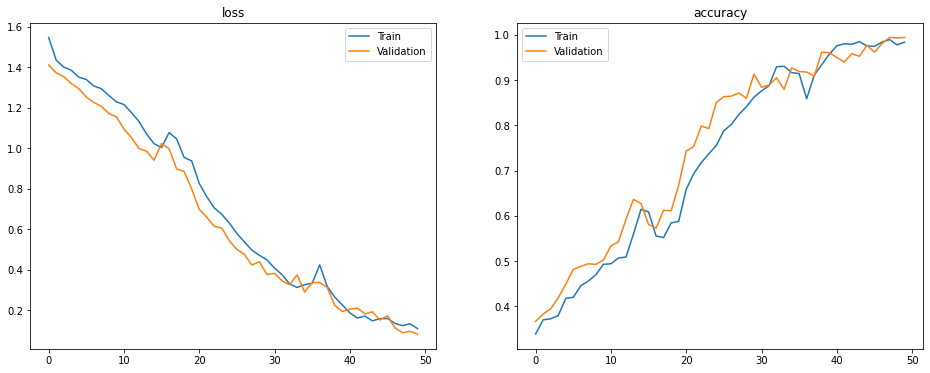

In [14]:
history_epoch.plot_history()

In [15]:
labels = [int(b.item()) for a, b in test]
preds = []
for X, Y in testloader:
    X = X.to(device).float()
    with torch.no_grad():
        pred = model(X)
        pred = pred.softmax(-1).argmax(-1)
        preds.extend(pred.cpu().numpy())

len(labels), len(preds)

(882, 864)

In [17]:
import utils

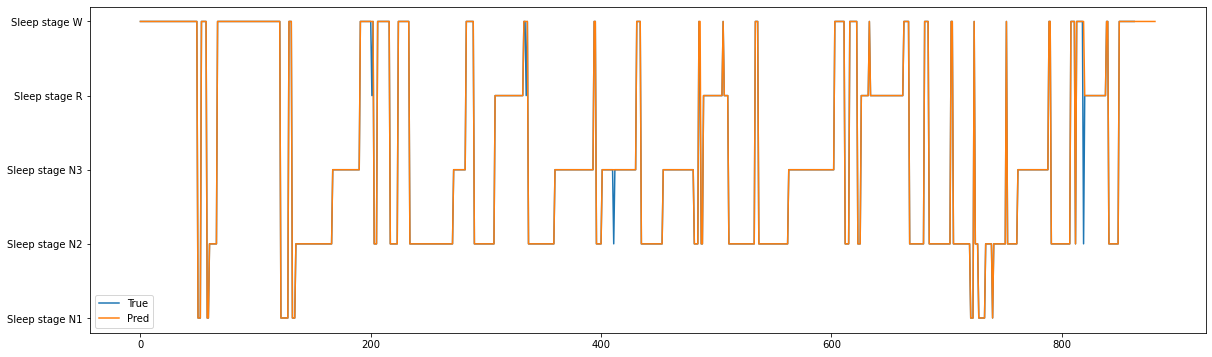

In [18]:
plt.figure(figsize=(20,6))
utils.plot_labels(labels, preds, test.id_to_class_dict)
plt.show()